In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.stats
import sklearn.decomposition.pca
import sklearn.cluster
import sklearn.model_selection
import sklearn.ensemble
import sklearn.metrics

# Employee Attrition

## Loading data

In [2]:
# Load data
employees = pd.read_csv("hr_attrition_train.csv", index_col=0)
employees.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
id,,,,,,,,,,
1,0.38,0.53,2,157,3,0,1,0,sales,low
2,0.80,0.86,5,262,6,0,1,0,sales,medium
3,0.11,0.88,7,272,4,0,1,0,sales,medium
4,0.72,0.87,5,223,5,0,1,0,sales,low
5,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
employees.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
count,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000.000000,13000,13000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3536,6312
mean,0.618806,0.716709,3.804077,200.909769,3.390000,0.147077,0.214077,0.016462,NaN,NaN
std,0.246630,0.170237,1.209814,49.484224,1.312204,0.354196,0.410196,0.127247,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.450000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.650000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,244.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


The first $5$ features are numerical in nature but the remaining 5 are categorical. "Work_accident" is described as a numerical feature in the metadata but because it can only take on values of $0$ and $1$ (see min/max above and the number of unique values below), it may as well be treated as a boolean.

In [4]:
employees.nunique()

satisfaction_level        92
last_evaluation           65
number_project             6
average_montly_hours     215
time_spend_company         8
Work_accident              2
left                       2
promotion_last_5years      2
sales                     10
salary                     3
dtype: int64

### Fixing column names and editing binary features
There are some typos in the column names that I want to fix in the code here for the sake of consistency and so that I don't keep making typos further down in the code. I am leaving the data itself untouched so that the code is compatible with different versions of the data.

Furthermore, the features "left", and "promotion_last_5years" are converted to boolean as they are binary flags.

In [5]:
def change_column_names_and_boolean_features(df):
    df.rename(
        columns={
            "number_project": "number_projects",
            "average_montly_hours": "average_monthly_hours",
            "time_spend_company": "time_spent_company",
            "Work_accident": "num_work_accidents",
            "sales": "department"}, 
        inplace=True)
    
    if "left" in df.keys():
        df["left"] = df["left"].astype(bool)
    df["promotion_last_5years"] = df["promotion_last_5years"].astype(bool)

change_column_names_and_boolean_features(employees)
employees.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,num_work_accidents,left,promotion_last_5years,department,salary
id,,,,,,,,,,
1,0.38,0.53,2,157,3,0,True,False,sales,low
2,0.80,0.86,5,262,6,0,True,False,sales,medium
3,0.11,0.88,7,272,4,0,True,False,sales,medium
4,0.72,0.87,5,223,5,0,True,False,sales,low
5,0.37,0.52,2,159,3,0,True,False,sales,low


### Data quality
There are no null values in the dataset, so no further cleaning is required.

In [6]:
employees.isnull().any()

satisfaction_level       False
last_evaluation          False
number_projects          False
average_monthly_hours    False
time_spent_company       False
num_work_accidents       False
left                     False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

## Feature distributions
- There appears to be a bimodal trend that splits employees into two, strongly overlapping groups based on the satisfaction levels, evaluation scores, and average monthly working hours.
- The number of projects and time spent at the company appear to be poisson distributed

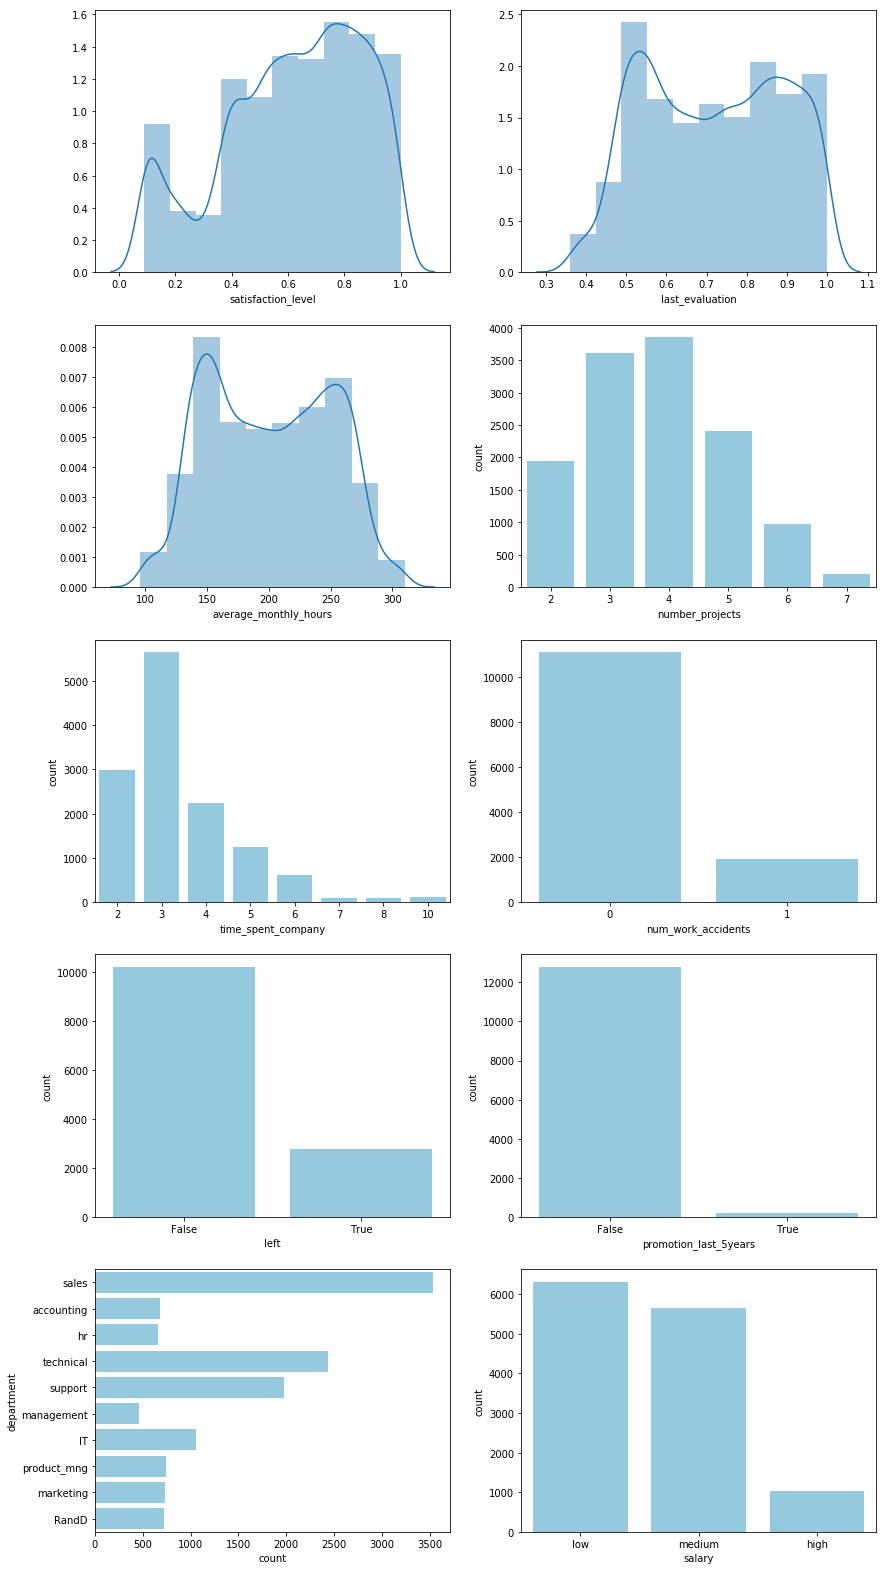

In [7]:
fig, ax = plt.subplots(5, 2, figsize=(14, 28));
sns.distplot(employees["satisfaction_level"], bins=10, ax=ax[0, 0]);
sns.distplot(employees["last_evaluation"], bins=10, ax=ax[0, 1]);
sns.distplot(employees["average_monthly_hours"], bins=10, ax=ax[1, 0]);
sns.countplot(employees["number_projects"], color="skyblue", ax=ax[1, 1]);
sns.countplot(employees["time_spent_company"], color="skyblue", ax=ax[2, 0]);
sns.countplot(employees["num_work_accidents"], color="skyblue", ax=ax[2, 1]);
sns.countplot(employees["left"], color="skyblue", ax=ax[3, 0]);
sns.countplot(employees["promotion_last_5years"], color="skyblue", ax=ax[3, 1]);
sns.countplot(y=employees["department"], color="skyblue", ax=ax[4, 0]);
sns.countplot(employees["salary"], color="skyblue", ax=ax[4, 1]);

## Individual feature relationships
If we split employees into two groups, those who have left and those who haven't, then the first step is to look at how individual features vary between these groups independently.

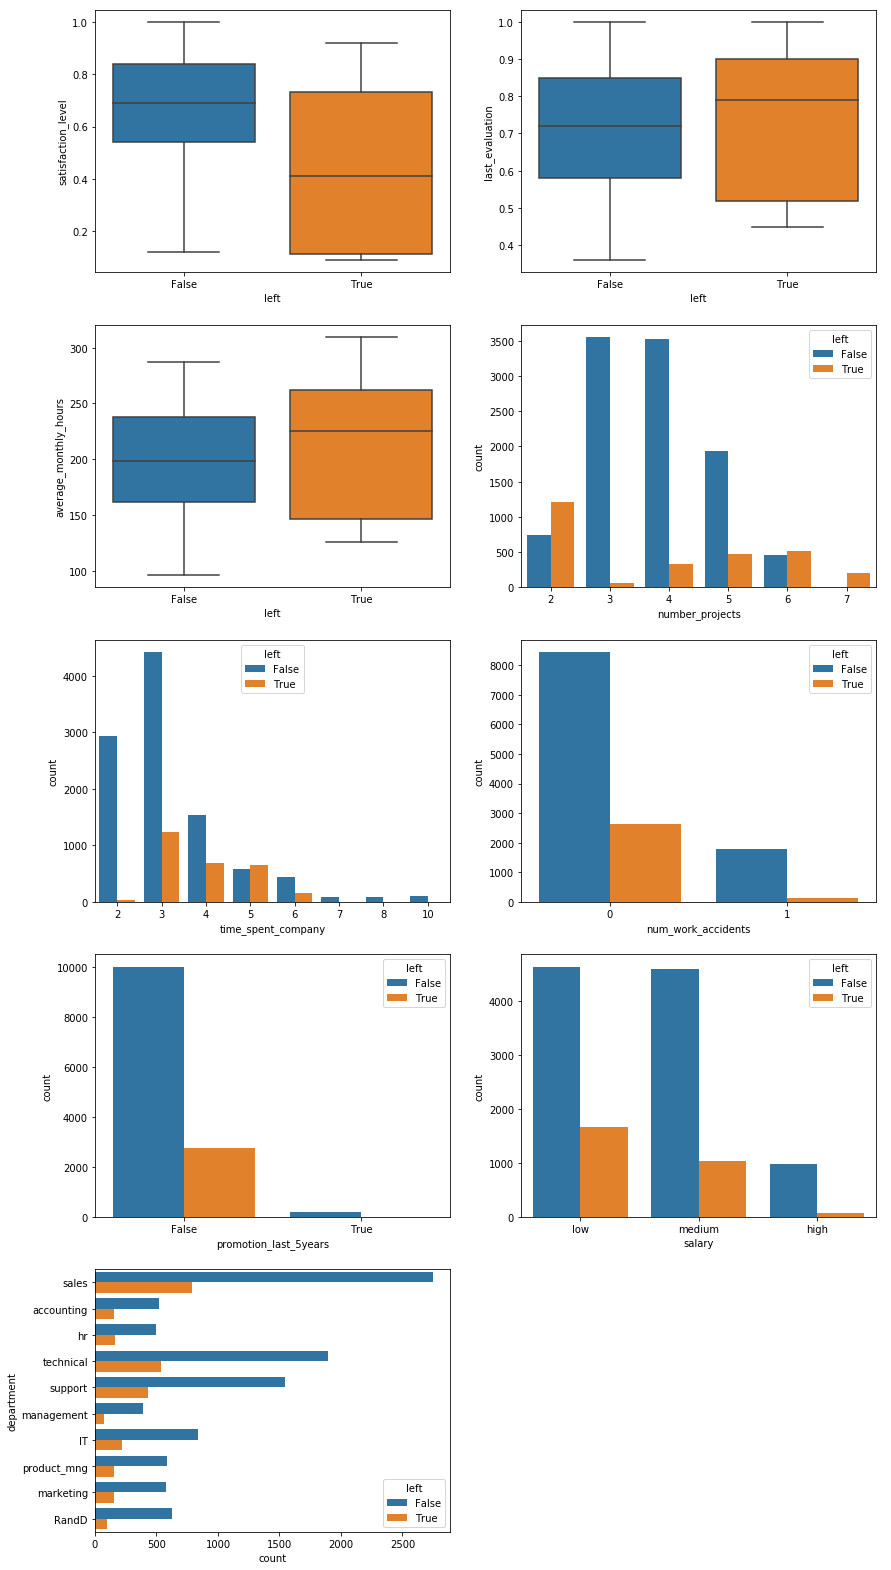

In [8]:
fig, ax = plt.subplots(5, 2, figsize=(14, 28));
sns.boxplot(data=employees, x="left", y="satisfaction_level", ax=ax[0, 0]);
sns.boxplot(data=employees, x="left", y="last_evaluation", ax=ax[0, 1]);
sns.boxplot(data=employees, x="left", y="average_monthly_hours", ax=ax[1, 0]);
sns.countplot(data=employees, x="number_projects", hue="left", ax=ax[1, 1]);
sns.countplot(data=employees, x="time_spent_company", hue="left", ax=ax[2, 0]);
sns.countplot(data=employees, x="num_work_accidents", hue="left", ax=ax[2, 1]);
sns.countplot(data=employees, x="promotion_last_5years", hue="left", ax=ax[3, 0]);
sns.countplot(data=employees, y="department", hue="left", ax=ax[4, 0]);
sns.countplot(data=employees, x="salary", hue="left", ax=ax[3, 1]);
ax[4, 1].axis("off");

Several initial hypotheses can be formed from these visuals:

- As expected, satisfaction level plays an important role in whether an employee leaves the company.
- Employees with both a large **and** small number of projects, i.e. over- and underworked employees, are more likely to leave. The employees that stay at the company occupy a "golden middle" in terms of workload.
- The vast majority of leaving employees only do so after at least $3$ years at the company. However, once an employee stays for a very long time, at least $6$ years, they appear to remain loyal to the company.

Of particular note is that every single employee with $7$ projects left the company. This is a total of $202$ employees.

In [9]:
(employees["number_projects"] == 7).sum()

202

The barplots can also be normalized to show relative frequencies rather than absolute counts. This lets us ignore the class imbalance since the majority of employees in the dataset did not leave the company.

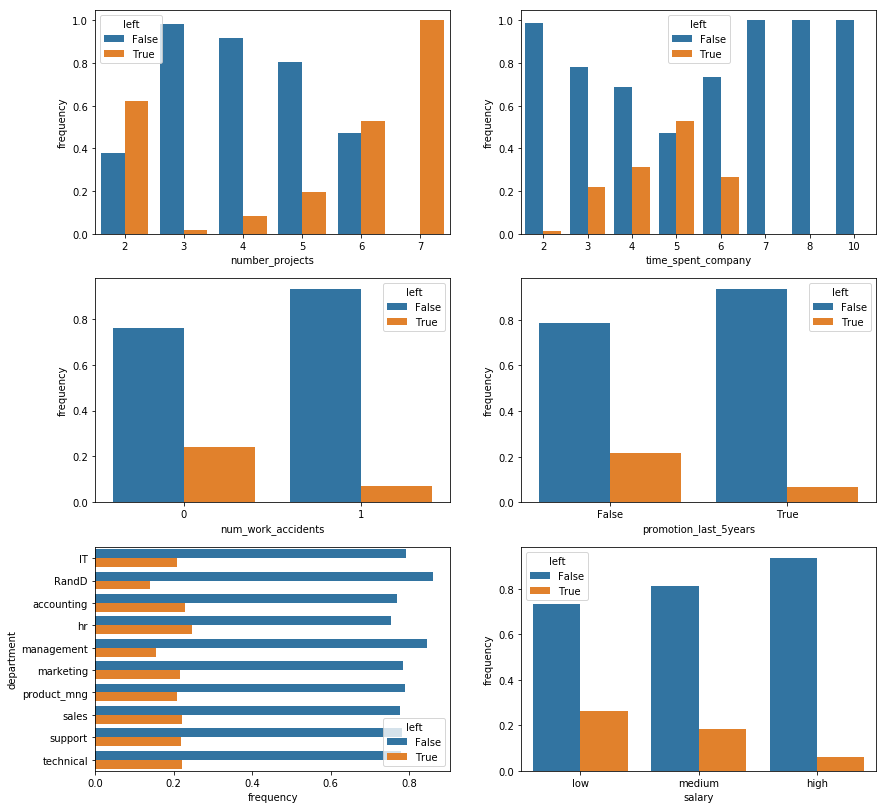

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(14, 14));
sns.barplot(
    data=employees.groupby(["number_projects", "left"]).size().unstack().apply(
        lambda x: x/x.sum(), axis=1).reset_index().melt(
        id_vars="number_projects", value_name="frequency"), 
    x="number_projects", y="frequency", hue="left", ax=ax[0, 0]);
sns.barplot(
    data=employees.groupby(["time_spent_company", "left"]).size().unstack().apply(
        lambda x: x/x.sum(), axis=1).reset_index().melt(
        id_vars="time_spent_company", value_name="frequency"), 
    x="time_spent_company", y="frequency", hue="left", ax=ax[0, 1]);
sns.barplot(
    data=employees.groupby(["num_work_accidents", "left"]).size().unstack().apply(
        lambda x: x/x.sum(), axis=1).reset_index().melt(
        id_vars="num_work_accidents", value_name="frequency"), 
    x="num_work_accidents", y="frequency", hue="left", ax=ax[1, 0]);
sns.barplot(
    data=employees.groupby(["promotion_last_5years", "left"]).size().unstack().apply(
        lambda x: x/x.sum(), axis=1).reset_index().melt(
        id_vars="promotion_last_5years", value_name="frequency"), 
    x="promotion_last_5years", y="frequency", hue="left", ax=ax[1, 1]);
sns.barplot(
    data=employees.groupby(["department", "left"]).size().unstack().apply(
        lambda x: x/x.sum(), axis=1).reset_index().melt(
        id_vars="department", value_name="frequency"), 
    y="department", x="frequency", hue="left", ax=ax[2, 0]);
sns.barplot(
    data=employees.groupby(["salary", "left"]).size().unstack().apply(
        lambda x: x/x.sum(), axis=1).reset_index().melt(
        id_vars="salary", value_name="frequency"), 
    x="salary", y="frequency", hue="left", ax=ax[2, 1], 
    order=["low", "medium", "high"]);

From the normalized barplots we can see the following:
- Work accidents, surprisingly, _decrease_ the probability of an employee leaving the company. It is worth noting that there may be an inherent bias in this assertion as the dataset most likely does not include employees who became unable to work due to an accident. 
- Receiving a promotion within the last 5 years, unsurprisingly, also decreases that probability.
- Management and R&D employees are slightly less likely to leave but for the most part, the department an employee works in seems to have an insignificant impact on their likelihood of leaving.
- The probability of leaving is, unsurprisingly, inversely proportional to an employee's salary.

## Correlations
There are weak correlations between features, in particular the number of projects, the average number of hours worked, and the last evaluation score show minor correlation. These correlation coefficients are not high enough, however, to warrant immediate concern.

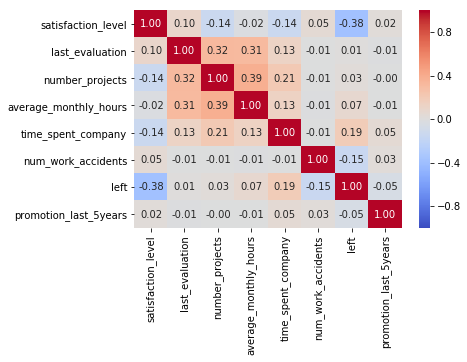

In [11]:
sns.heatmap(
    employees.corr(), cmap="coolwarm", 
    vmin=-1, vmax=1, annot=True, fmt=".2f")

## Clustering
Clustering data with mixed continuous and categorical variables is always tricky. Nonetheless, if we look at a principal component analysis with 2 components of the continuous variables then we notice that there appear to be three main groups of employees who leave the company.

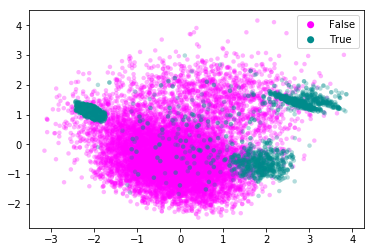

In [12]:
pca = sklearn.decomposition.pca.PCA(n_components=2).fit_transform(
    employees.drop(
    ["num_work_accidents", "left", 
     "promotion_last_5years", "department", "salary"], 
    axis=1).apply(lambda x: (x - x.mean()) / x.std()))

fig, ax = plt.subplots();
for val, color in [(False, "magenta"), (True, "darkcyan")]:
    ax.scatter(
        pca[employees["left"].values == val, 0], 
        pca[employees["left"].values == val, 1], 
        c=color, label=val, alpha=0.3, edgecolors="none", s=20);
l = plt.legend()
l.legendHandles[0].set_alpha(1)
l.legendHandles[1].set_alpha(1)
l.legendHandles[0].set_sizes((50,))
l.legendHandles[1].set_sizes((50,))

Let's attempt to cluster these three groups.

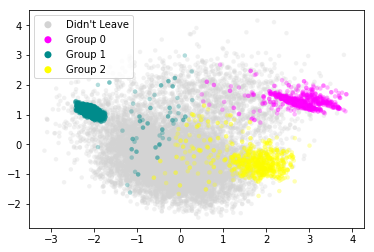

In [13]:
# The random_state value makes sure that my descriptions in the text are 
# consistent with the class labels.
cluster = sklearn.cluster.KMeans(n_clusters=3, random_state=991).fit_predict(
    pca[employees["left"].values == True, :])

fig, ax = plt.subplots();
ax.scatter(
    pca[employees["left"].values == False, 0], 
    pca[employees["left"].values == False, 1], 
    c="lightgray", label="Didn't Leave", alpha=0.3, 
    edgecolors="none", s=20);
for val, color in [(0, "magenta"), (1, "darkcyan"), (2, "yellow")]:
    pca_leavers = pca[employees["left"].values == True, :]
    ax.scatter(
        pca_leavers[cluster == val, 0], 
        pca_leavers[cluster == val, 1], 
        c=color, label="Group {}".format(val), alpha=0.3, 
        edgecolors="none", s=20);
l = plt.legend()
l.legendHandles[0].set_alpha(1)
l.legendHandles[1].set_alpha(1)
l.legendHandles[2].set_alpha(1)
l.legendHandles[3].set_alpha(1)
l.legendHandles[0].set_sizes((50,))
l.legendHandles[1].set_sizes((50,))
l.legendHandles[2].set_sizes((50,))
l.legendHandles[3].set_sizes((50,))

Let's now look at the distribution of features for each of these subgroups individually.

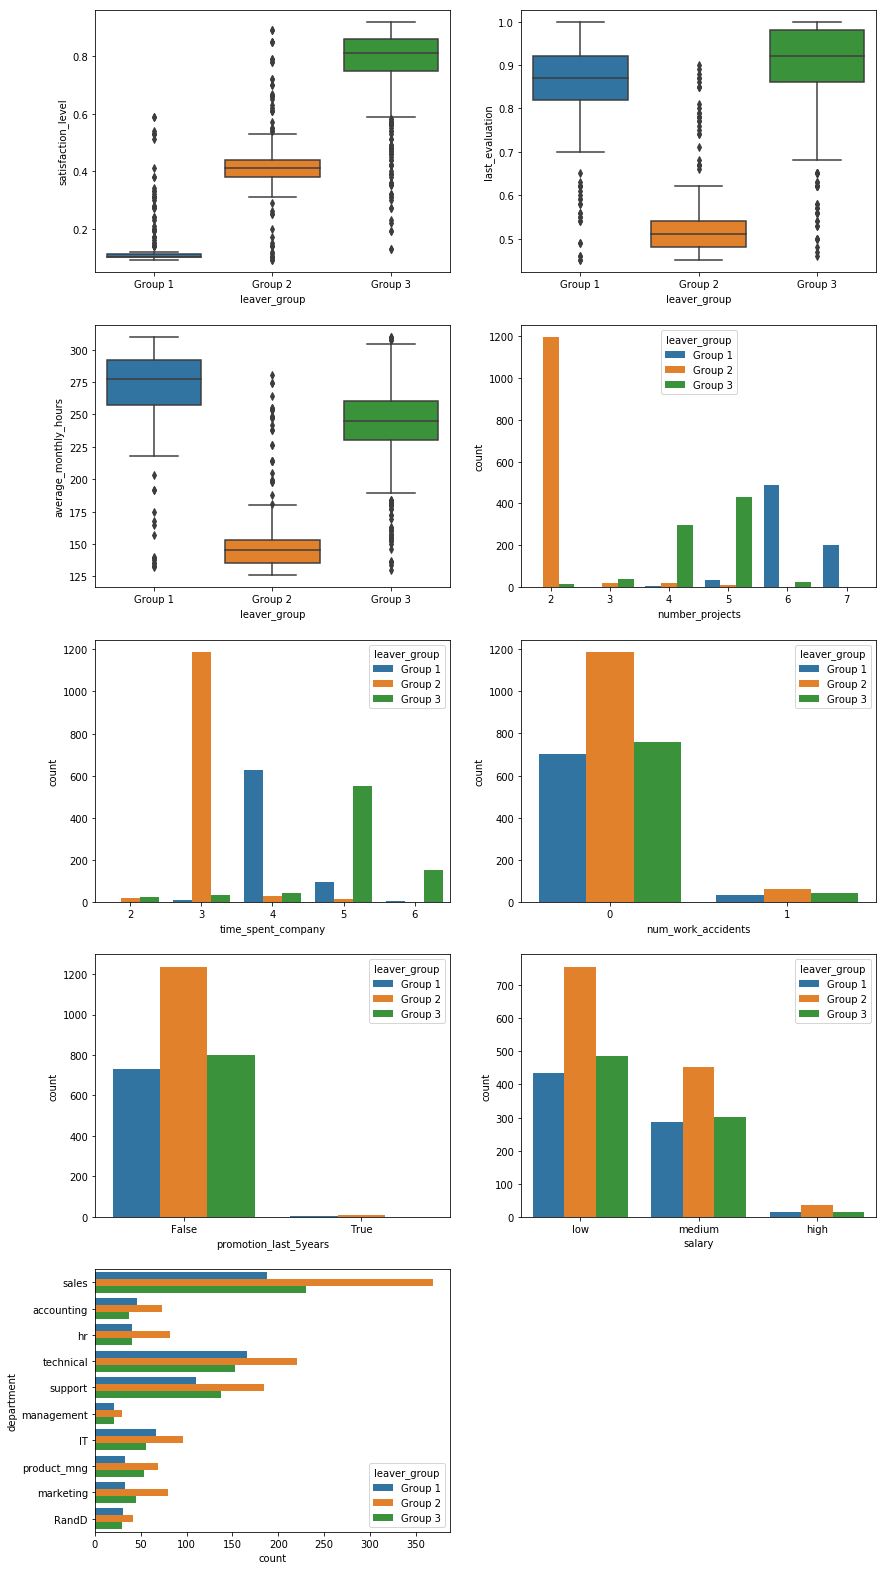

In [14]:
leavers = employees.loc[employees["left"] == True, :].copy()
leavers["leaver_group"] = ["Group {}".format(ii+1) for ii in cluster]

fig, ax = plt.subplots(5, 2, figsize=(14, 28));
sns.boxplot(data=leavers, x="leaver_group", y="satisfaction_level",
            order=["Group 1", "Group 2", "Group 3"], ax=ax[0, 0]);
sns.boxplot(data=leavers, x="leaver_group", y="last_evaluation",
            order=["Group 1", "Group 2", "Group 3"], ax=ax[0, 1]);
sns.boxplot(data=leavers, x="leaver_group", y="average_monthly_hours",
            order=["Group 1", "Group 2", "Group 3"], ax=ax[1, 0]);
sns.countplot(data=leavers, hue="leaver_group", x="number_projects",
              hue_order=["Group 1", "Group 2", "Group 3"], ax=ax[1, 1]);
sns.countplot(data=leavers, hue="leaver_group", x="time_spent_company",
              hue_order=["Group 1", "Group 2", "Group 3"], ax=ax[2, 0]);
sns.countplot(data=leavers, hue="leaver_group", x="num_work_accidents",
              hue_order=["Group 1", "Group 2", "Group 3"], ax=ax[2, 1]);
sns.countplot(data=leavers, hue="leaver_group", x="promotion_last_5years",
              hue_order=["Group 1", "Group 2", "Group 3"], ax=ax[3, 0]);
sns.countplot(data=leavers, hue="leaver_group", y="department", 
              hue_order=["Group 1", "Group 2", "Group 3"], ax=ax[4, 0]);
sns.countplot(data=leavers, hue="leaver_group", x="salary", 
              hue_order=["Group 1", "Group 2", "Group 3"], ax=ax[3, 1]);
ax[4, 1].axis("off");

This stratification paints an interesting picture and lets us make the following hypotheses:
- Employees in group 1 are overworked. They work the longest hours, have the highest number of projects (all of the employees with $7$ projects appear to be in this group), and are extremely dissatisfied because of it. Nonetheless, they are evaluated very highly, meaning they most likely leave of their own volition to improve their work-life balance.
- Group 2 consists of employees who are underworked and evaluated poorly for it. Almost all of them stayed with the company for $3$ years but only worked on $2$ projects. Their average monthly working hours are notably lower than the other two groups. The most likely explanation is that these employees are either asked to leave by their employer or are fundamentally unhappy with and/or unsuited for their job.
- Group 3 is a curious group. They are very satisfied, scored high on their last evaluation, and appear to be in the "golden middle" with regards to the number of projects. They tend to stay with the company longer than the other two groups of leavers. These employees may have difficulty moving into senior positions within the company due to internal competition and therefore leave to advance their careers. Retirees may also fall into this group.

The categorical variables show no distinction between the groups but this is unsurprising as they were not used in the clustering.

## Predicting attrition
In order to more precisely predict employee attrition, we turn towards machine learning models that can identify more complex relationships between features.

### Converting categorical features
The first step is to convert categorical features into numerical, one-hot features. Specifically, the department and salary must be converted. The number of work accidents and the promotion status are boolean and can be used as-is.

In [15]:
employees_dummy = pd.get_dummies(employees)
employees_dummy["leaver_group"] = employees_dummy["left"].copy()
employees_dummy.loc[employees_dummy["leaver_group"] == True, 
                    "leaver_group"] = leavers["leaver_group"]
employees_dummy.loc[employees_dummy["leaver_group"] == False, 
                    "leaver_group"] = "Didn't leave"
employees_dummy.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,num_work_accidents,left,promotion_last_5years,department_IT,department_RandD,...,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium,leaver_group
id,,,,,,,,,,,,,,,,,,,,,
1,0.38,0.53,2,157,3,0,True,False,0,0,...,0,0,0,1,0,0,0,1,0,Group 2
2,0.80,0.86,5,262,6,0,True,False,0,0,...,0,0,0,1,0,0,0,0,1,Group 3
3,0.11,0.88,7,272,4,0,True,False,0,0,...,0,0,0,1,0,0,0,0,1,Group 1
4,0.72,0.87,5,223,5,0,True,False,0,0,...,0,0,0,1,0,0,0,1,0,Group 3
5,0.37,0.52,2,159,3,0,True,False,0,0,...,0,0,0,1,0,0,0,1,0,Group 2


In [16]:
employees_dummy["left"].value_counts()

False    10217
True      2783
Name: left, dtype: int64

In [17]:
employees_dummy["leaver_group"].value_counts()

Didn't leave    10217
Group 2          1246
Group 3           802
Group 1           735
Name: leaver_group, dtype: int64

### Class imbalance
In general, class imbalance can be handled via up- or downsampling of individual categories. A number of sampling techniques exist and could be explored. However, the number of samples in each category is much larger than the number of features. Therefore, downsampling the larger category still retains a sufficient number of data points to train a model.

In [18]:
# downsample 'False' group
x = employees_dummy.groupby("left").apply(
    lambda x: x.sample(n = employees_dummy.groupby("left").size().min()))
y = x["left"]
x = x.drop(["left", "leaver_group"], axis=1)
y.value_counts()

True     2783
False    2783
Name: left, dtype: int64

In [19]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.30)

### Model selection
I chose a random forest model. The reasons for this are:
- The features are very heterogeneous, i.e. `satisfaction_level` and `last_evaluation` are bounded by 0 and 1, `average_monthly_hours` is effectively unbounded, `time_spent_company` and `number_projects` appear poisson distributed, and the remaining features are categorical. Normalizing them to make them compatible with a logistic regression, for example, requires assumptions I don't want to make if I don't have to.
- Ensemble methods are typically among the most powerful classification algorithms.

I will tune the number of trees in the forest as well as their maximum depth using 5-fold cross-validation.

In [20]:
cv = sklearn.model_selection.GridSearchCV(
    estimator=sklearn.ensemble.RandomForestClassifier(), 
    param_grid={"max_depth": [3, 5, 10, 25, 50, 75, 100, None],
                "n_estimators": [5, 10, 25, 50, 75, 100, 150, 200]}, 
    n_jobs=6, cv=5, return_train_score=False).fit(x_train, y_train)

In [21]:
print("Best CV score: {:.4f}".format(cv.best_score_))
print("Best parameters:")
print("    max_depth={}".format(cv.best_params_["max_depth"]))
print("    n_estimators={}".format(cv.best_params_["n_estimators"]))

Best CV score: 0.9689
Best parameters:
    max_depth=50
    n_estimators=75


### Training and Evaluation
The most basic metric, and the one that all other metrics build on, is the confusion matrix.

In [22]:
model = cv.best_estimator_.fit(x_train, y_train)

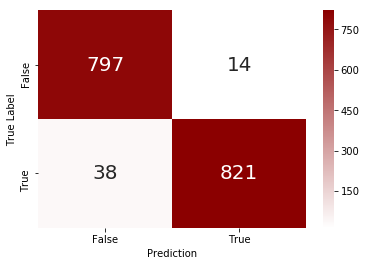

In [23]:
cm = pd.DataFrame({
    "True Label": y_test.values, 
    "Prediction": model.predict(x_test)}).groupby(
    ["True Label", "Prediction"]).size().unstack()
colormap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "whitered", ["white", "darkred"])
sns.heatmap(
    cm, annot=True, fmt="d", 
    annot_kws={"fontsize": 20}, cmap=colormap);

The model has some difficulty with false negatives, i.e. it misses about $5\%$ of employees that leave the company. Objectively, however, the model exhibits adequate accuracy to not require further exploration and fine-tuning of the model, i.e. it's good enough for now.

### Feature importance
A look at the feature importances of the model confirm our intuition that satisfaction level, workload (in terms of projects and working hours), time spent at the company, and evaluation scores have the biggest impact on the attrition prediction. Curiously, salary seems much less important than indicated in the EDA above.

In [24]:
pd.DataFrame({
    "Feature": x_train.columns,
    "Importance": model.feature_importances_}).sort_values(
    "Importance", ascending=False)

,Feature,Importance
0,satisfaction_level,0.261806
4,time_spent_company,0.231742
2,number_projects,0.158867
3,average_monthly_hours,0.144305
1,last_evaluation,0.144160
5,num_work_accidents,0.011303
18,salary_low,0.006678
17,salary_high,0.006016
14,department_sales,0.005251
16,department_technical,0.005025


### Predicting attrition in test data file
As part of the assessment, I want to apply the model to the test data set.

In [25]:
# Load data
employees_test = pd.read_csv("hr_attrition_test.csv", index_col=0)
change_column_names_and_boolean_features(employees_test)
employees_test.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,num_work_accidents,promotion_last_5years,department,salary
id,,,,,,,,,
13001,0.62,0.94,4,252,4,0,False,accounting,low
13002,0.38,0.52,2,171,3,0,False,accounting,medium
13003,0.80,0.77,4,194,3,0,False,accounting,medium
13004,0.61,0.42,3,104,2,0,False,hr,medium
13005,0.61,0.56,4,176,3,0,False,hr,medium


Features are similarly distributed in the test dataset and there are no missing values

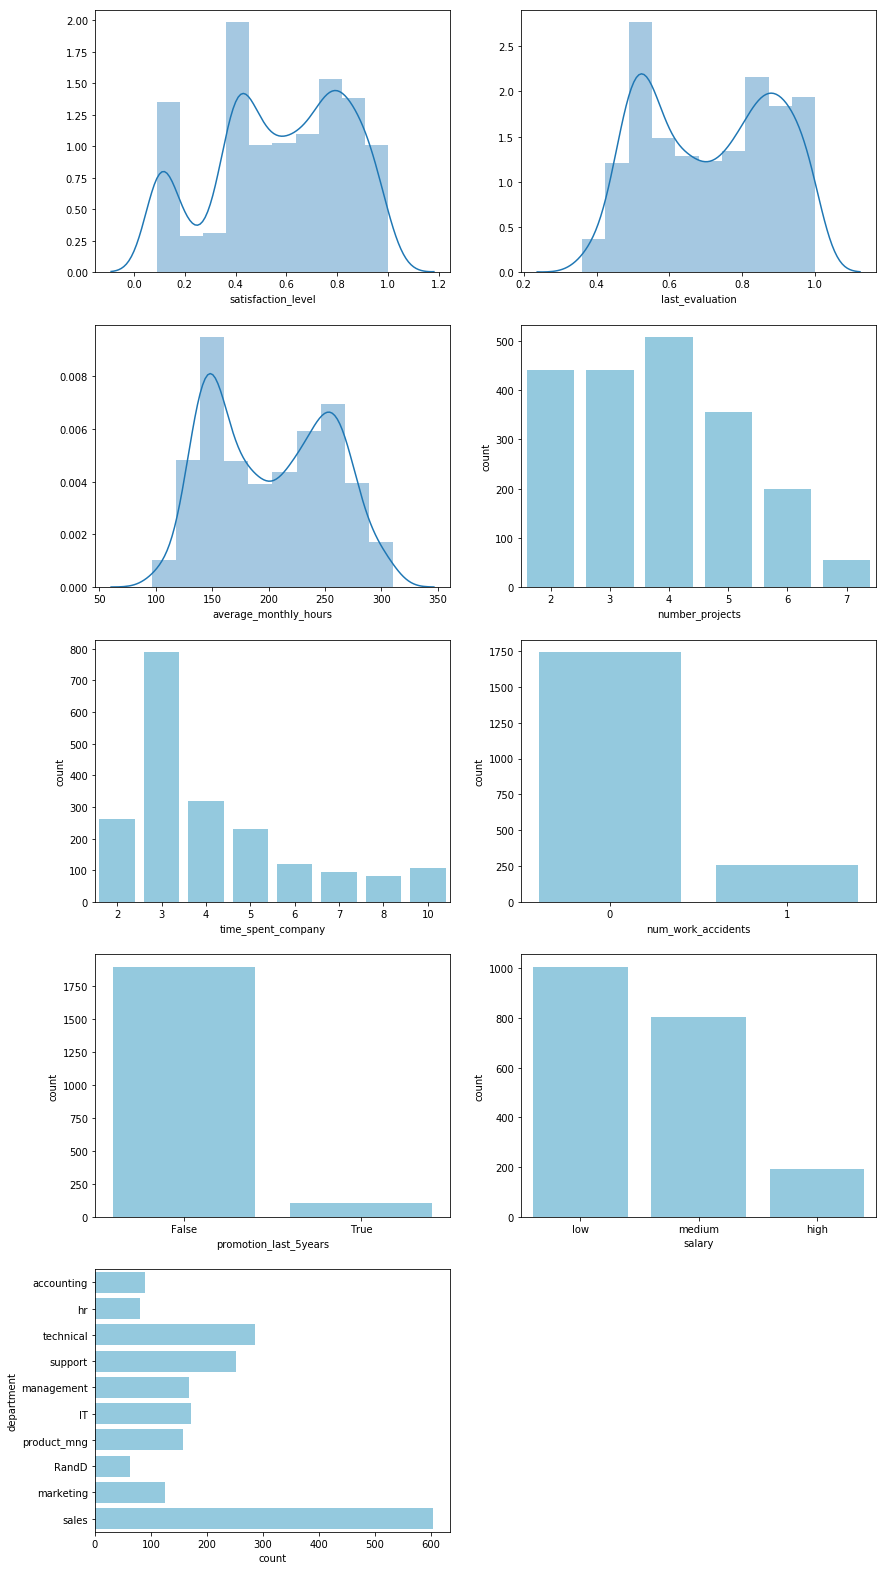

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(14, 28));
sns.distplot(employees_test["satisfaction_level"], bins=10, ax=ax[0, 0]);
sns.distplot(employees_test["last_evaluation"], bins=10, ax=ax[0, 1]);
sns.distplot(employees_test["average_monthly_hours"], bins=10, ax=ax[1, 0]);
sns.countplot(employees_test["number_projects"], color="skyblue", ax=ax[1, 1]);
sns.countplot(employees_test["time_spent_company"], color="skyblue", ax=ax[2, 0]);
sns.countplot(employees_test["num_work_accidents"], color="skyblue", ax=ax[2, 1]);
sns.countplot(employees_test["promotion_last_5years"], color="skyblue", ax=ax[3, 0]);
sns.countplot(y=employees_test["department"], color="skyblue", ax=ax[4, 0]);
sns.countplot(employees_test["salary"], color="skyblue", ax=ax[3, 1]);
ax[4, 1].axis("off");

In [27]:
employees_test.isnull().any()

satisfaction_level       False
last_evaluation          False
number_projects          False
average_monthly_hours    False
time_spent_company       False
num_work_accidents       False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

Performing a PCA-style clustering with the continuous variables shows that the test data set overlaps strongly with one of the leaver groups identified earlier. We can safely assume that the test data stems from the same distribution as the training data and the model should be applicable to it.

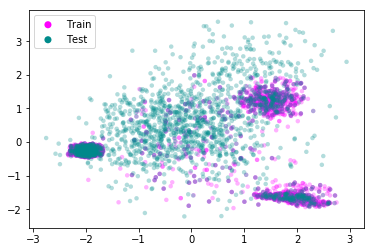

In [28]:
tmp = pd.concat((leavers.drop(["left", "leaver_group"], axis=1), employees_test))
tmp["traintest"] = "Train"
tmp.loc[13001:, "traintest"] = "Test"

pca = sklearn.decomposition.pca.PCA(n_components=2).fit_transform(
    tmp.drop(
    ["num_work_accidents", "promotion_last_5years", 
     "department", "salary", "traintest"], 
    axis=1).apply(lambda x: (x - x.mean()) / x.std()))

fig, ax = plt.subplots();
for val, color in [("Train", "magenta"), ("Test", "darkcyan")]:
    ax.scatter(
        pca[tmp["traintest"].values == val, 0], 
        pca[tmp["traintest"].values == val, 1], 
        c=color, label=val, alpha=0.3, edgecolors="none", s=20);
l = plt.legend()
l.legendHandles[0].set_alpha(1)
l.legendHandles[1].set_alpha(1)
l.legendHandles[0].set_sizes((50,))
l.legendHandles[1].set_sizes((50,))

Convert categorical features

In [29]:
employees_test_dummy = pd.get_dummies(employees_test)
employees_test_dummy.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spent_company,num_work_accidents,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
id,,,,,,,,,,,,,,,,,,,,
13001,0.62,0.94,4,252,4,0,False,0,0,1,0,0,0,0,0,0,0,0,1,0
13002,0.38,0.52,2,171,3,0,False,0,0,1,0,0,0,0,0,0,0,0,0,1
13003,0.80,0.77,4,194,3,0,False,0,0,1,0,0,0,0,0,0,0,0,0,1
13004,0.61,0.42,3,104,2,0,False,0,0,0,1,0,0,0,0,0,0,0,0,1
13005,0.61,0.56,4,176,3,0,False,0,0,0,1,0,0,0,0,0,0,0,0,1


Predict attrition and save in file.

In [30]:
output = pd.DataFrame({
    "id": employees_test_dummy.index, 
    "left": model.predict(employees_test_dummy).astype(int)})
output.to_csv(
    path_or_buf="hr_attrition_prediction.csv", 
    header=True, index=False)

### Training on subgroups
There are very few false positives. As mentioned, however, about $5\%$ of employees who left the company are not being identified as such. To get a better idea with which employees the model struggles, we'll look at the subgroups of leavers identified above.

Balance classes through downsampling.

In [31]:
x = employees_dummy.groupby("leaver_group").apply(
    lambda x: x.sample(n = employees_dummy.groupby("leaver_group").size().min()))
y = x["leaver_group"]
x = x.drop(["left", "leaver_group"], axis=1)
y.value_counts()

Group 2         735
Group 3         735
Group 1         735
Didn't leave    735
Name: leaver_group, dtype: int64

Set up training and test set.

In [32]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.30)

Perform cross validation.

In [33]:
cv = sklearn.model_selection.GridSearchCV(
    estimator=sklearn.ensemble.RandomForestClassifier(), 
    param_grid={"max_depth": [3, 5, 10, 25, 50, 75, 100, None],
                "n_estimators": [5, 10, 25, 50, 75, 100, 150, 200]}, 
    n_jobs=6, cv=5, return_train_score=False).fit(x_train, y_train)

In [34]:
print("Best CV score: {:.4f}".format(cv.best_score_))
print("Best parameters:")
print("    max_depth={}".format(cv.best_params_["max_depth"]))
print("    n_estimators={}".format(cv.best_params_["n_estimators"]))

Best CV score: 0.9417
Best parameters:
    max_depth=75
    n_estimators=50


Fit the model and look at confusion matrix.

In [35]:
model = cv.best_estimator_.fit(x_train, y_train)

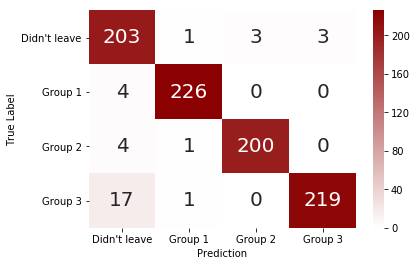

In [36]:
cm = pd.DataFrame({
    "True Label": y_test.values, 
    "Prediction": model.predict(x_test)}).groupby(
    ["True Label", "Prediction"]).size().unstack().fillna(0).astype(int)
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"fontsize": 20}, cmap=colormap)

The model struggles primarily with the third group, the employees who leave despite being happy with their work and not overworked. Most likely there are factors not present in this dataset that better describe their reason for leaving.

## Summary
- The strongest predictors of an employee leaving are satisfaction, number of projects, working hours, and tenure at the company
- Employees who leave can be categorized into three broad groups:
    1. Overworked employees who are, on average, unhappy with their work.
    2. Underutilized employees who are, on average, indifferent to their work.
    3. Employees who leave, despite performing well and being happy, possibly due to a lack of career advancement opportunities.
- Salary has a minor effect on the probability of leaving, although this may not be a causal relationship but an accidental correlation, e.g. due to employees with a longer tenure having a higher salary.
- The department in which an employee works appears to play no significant role in predicting attrition.
- A random forest classification model can predict employee attrition with an accuracy of approximately $95\%$. It struggles more with false negatives than false positives.
    - Training the classifier to identify employee subgroups shows that it struggles most with the third group of leavers, i.e. those who leave despite being happy and performing well. Capturing additional features in the data set, such as career progression beyond the last promotion or personality traits and career wishes, may alleviate this.